In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install -q imagecorruptions

In [3]:
from utils import *
from utils.callbacks.cyclicLR import CyclicLR
from utils.callbacks.metrics import ClassificationMetrics
from utils.losses import SparseCategoricalFocalLoss

In [4]:
loader = DataLoader(split_method='balanced')

print('\nTrain data distribution')
loader.print_data_distribution('train', False)

print('\nValidation data distribution')
loader.print_data_distribution('val', False)

Class weights: {0: 4.669425287356322, 1: 2.0600405679513183, 2: 1.87293683725219, 3: 0.31391700795919947, 4: 1.7213559322033898}
Total train: 20312, Total val: 1085

Train data distribution
3    12941
4     2360
2     2169
1     1972
0      870
Name: label, dtype: int64

Validation data distribution
4    217
3    217
2    217
1    217
0    217
Name: label, dtype: int64


Train data
Batch X:  (4, 456, 456, 3) -2.21809238891261 3.4227696874715763
Batch Y:  (4, 5) 0.0 1.0


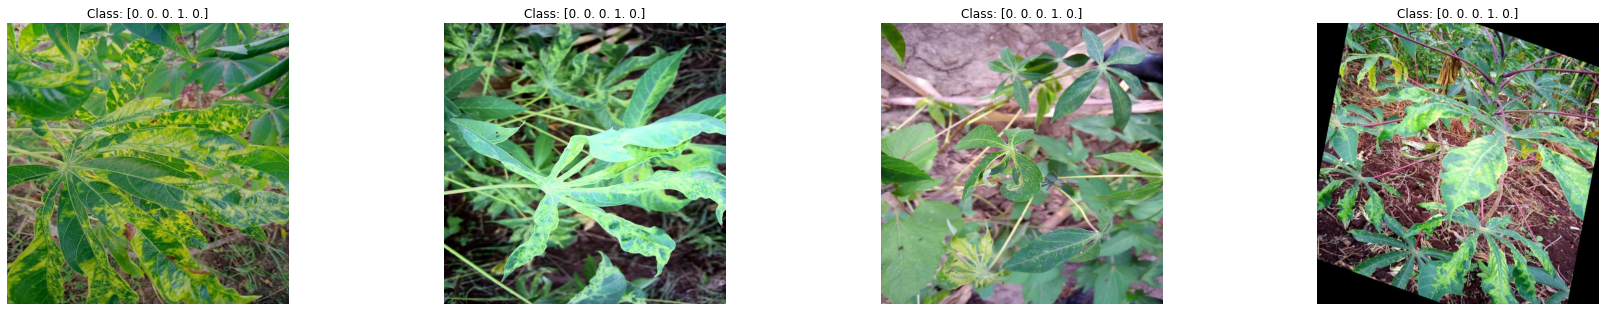

In [5]:
print('Train data')
loader.view_data(data='train', batch_size=4)

Validation data
Batch X:  (4, 456, 456, 3) -2.21809238891261 3.4227696874715763
Batch Y:  (4, 5) 0.0 1.0


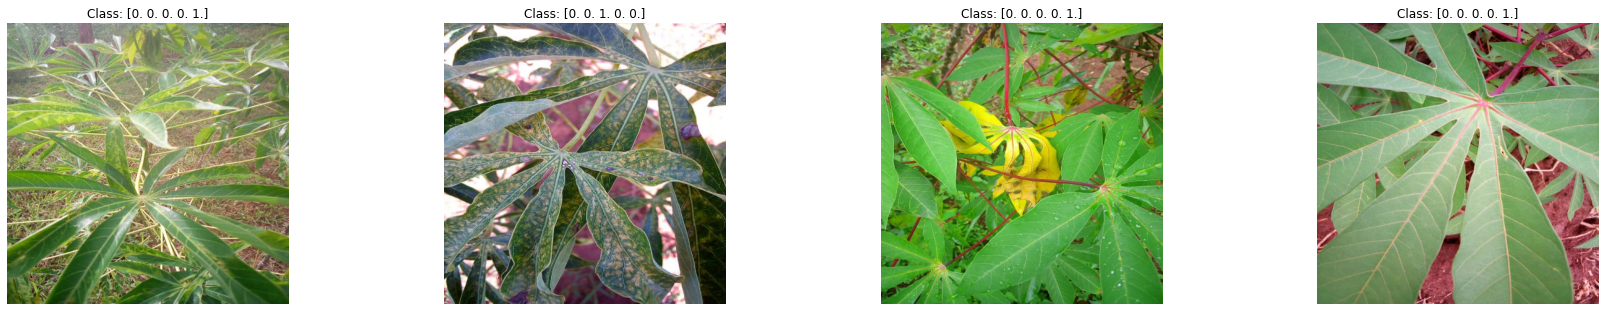

In [6]:
print('Validation data')
loader.view_data(data='val', batch_size=4)

In [7]:
with tf.distribute.MirroredStrategy().scope():
    model = Model()
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

## Model fitting

In [9]:
# start training
model.fit(
    x=loader.flow('train', batch_size=BATCH_SIZE),
    steps_per_epoch=loader.data_size('train')//BATCH_SIZE,
    
    class_weight=loader.class_weights,
    
    epochs=100,
    callbacks=[
        ClassificationMetrics(loader.flow('val', batch_size=2), loader.data_size('val')//2, 
                              f'model.h5', mode='categorical'),
        tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', mode='min', 
                                           verbose=1, save_best_only=True, save_weights_only=False),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                                        mode='min', restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                             verbose=1, mode='min', min_lr=1e-6, min_delta=0.01),
        tf.keras.callbacks.CSVLogger(filename='training_log.csv', separator=',', append=True),
        CyclicLR(base_lr=1e-4, max_lr=3e-4, step_size=loader.data_size('train')//BATCH_SIZE, 
                 mode='exp_range', gamma=0.9)
              ],
    
    validation_data=loader.flow('val', batch_size=2),
    validation_steps=loader.data_size('val')//2,
    
    use_multiprocessing=True
)

Epoch 1/100
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:batch_all_reduce: 427 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 427 all-reduces with algorithm = nccl, num_packs = 1
2539/2539 [==============================] - ETA: 0s - loss: 1.5746 - acc: 0.5783
Validation 1
541/542 [============================>.] - ETA: 0s
Classification report:
              precision    recall  f1-score   support

           0       0.80      0.56      0.66       217
           1       0.80      0.59      0.68       217
           2       0.82      0.79      0.80       216
           3       0.94      0.76      0.84       217
           4       0.49      0.88      0.62       217

    accuracy                           0.71      1084
   macro avg       0.77      0.71      0.72      1084
weighted avg       0.77      0.71      0.72      1084


Confusion matrix:
[[0.79738562 0.10759494 0.01932367 0.02285714 0.1790281

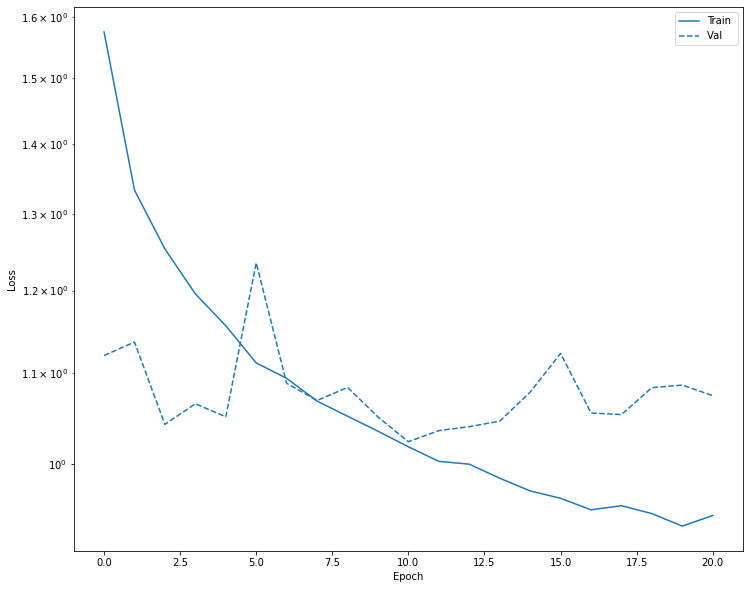

In [10]:
plot_loss(model.history, '', 0)

100%|██████████| 135/135 [00:25<00:00,  5.33it/s]



Classification report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.75       215
           1       0.82      0.80      0.81       216
           2       0.90      0.82      0.86       217
           3       0.90      0.82      0.86       215
           4       0.63      0.78      0.69       217

    accuracy                           0.79      1080
   macro avg       0.80      0.79      0.79      1080
weighted avg       0.80      0.79      0.79      1080



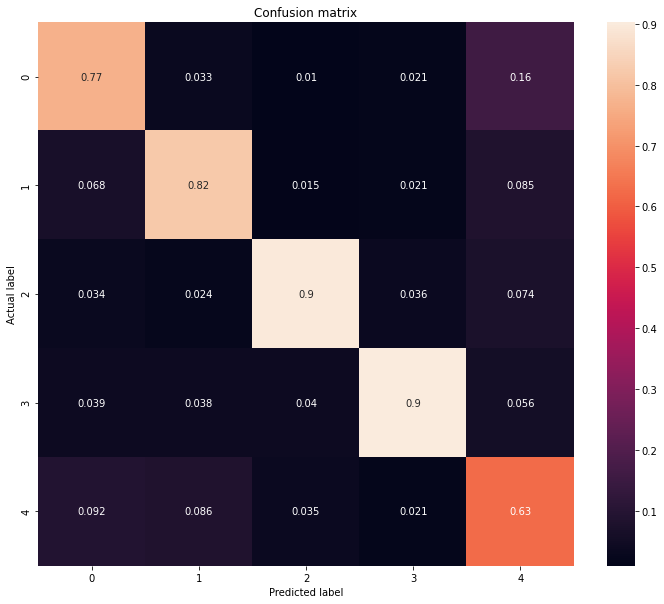

In [11]:
# evaluate model
loader.evaluate(model, 8)

In [12]:
loader.create_submission(
    model = model,
    path_to_csv = '../input/cassava-leaf-disease-classification/sample_submission.csv',
    path_to_images = '../input/cassava-leaf-disease-classification/test_images/'
)

         image_id  label
0  2216849948.jpg      4


In [13]:
min/val

NameError: name 'val' is not defined